In [1]:
import requests
import pandas as pd
import time

def get_repos(username, token):
    """Fetches all repositories of a given GitHub user."""
    repos = []
    page = 1
    while True:
        url = f"https://api.github.com/users/{username}/repos?page={page}&per_page=100"
        headers = {'Authorization': f'token {token}'}
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            raise Exception(f"Error fetching repositories: {response.status_code}")
        page_repos = response.json()
        if not page_repos:
            break
        repos.extend(page_repos)
        page += 1
    return repos

def get_commits_for_repos(username, repos, token):
    """Fetches commit data for each repository and accumulates commit counts."""
    all_commits_data = []
    repo_checkins = {}  # Track first check-in date for each repo
    repo_commits_cumulative = {}  # Track cumulative commits for each repo

    for repo in repos:
        repo_name = repo['name']
        print(f"Fetching commits for repository: {repo_name}")

        commits_url = f"https://api.github.com/repos/{username}/{repo_name}/commits"
        page = 1
        while True:
            headers = {'Authorization': f'token {token}'}
            response = requests.get(commits_url, params={'per_page': 100, 'page': page}, headers=headers)
            if response.status_code != 200:
                print(f"Error fetching commits for {repo_name}, page {page}: {response.status_code}")
                break
            response_data = response.json()
            if len(response_data) == 0:
                break

            for commit in response_data:
                try:
                    commit_date = commit['commit']['author']['date'][:10]  # YYYY-MM-DD
                    all_commits_data.append({'date': commit_date, 'repo': repo_name})
                except KeyError:
                    print(f"Error processing commit data for {repo_name}, commit: {commit}")

            page += 1

    return all_commits_data

def main():
    # Set up the GitHub username and token
    username = "ursa-mikail"
    token = "YOUR_TOKEN_HERE"  # Replace with your GitHub token (ciphered: U2FsdGVkX1+7TtLL8EZXcO+sDvRQ830mnmRH+1bPozCC3DDFIc4hyk/kAlvk6OBrlMhC6s/DVrAJypjnA/6zdQ==)

    # Fetch repositories
    repos = get_repos(username, token)

    # Fetch commits for all repositories
    commits_data = get_commits_for_repos(username, repos, token)

    # Convert commit data into DataFrame
    df = pd.DataFrame(commits_data)

    # Clean up repository names (remove extra spaces and lowercase)
    df['repo'] = df['repo'].str.strip().str.lower()

    # Sort by date and remove duplicates for unique repo-counting
    df = df.sort_values(by=['repo', 'date'])
    df = df.drop_duplicates(subset=['repo', 'date'])

    # Initialize variables for cumulative counts
    repo_checkins = {}
    repo_cumulative = []
    repo_commits_cumulative = {}

    # Loop through the commits and accumulate
    cumulative_repos = 0
    for idx, row in df.iterrows():
        repo = row['repo']
        if repo not in repo_checkins:
            # First check-in for the repository
            repo_checkins[repo] = row['date']
            cumulative_repos += 1  # Increment cumulative repo count

        # Accumulate commit count for this repository
        if repo not in repo_commits_cumulative:
            repo_commits_cumulative[repo] = 0
        repo_commits_cumulative[repo] += 1

        # Add cumulative commit count to the row
        row['cumulative_commits'] = repo_commits_cumulative[repo]
        repo_cumulative.append(cumulative_repos)

    df['cumulative_repos'] = repo_cumulative  # Add cumulative repo column

    # Save the results to a CSV file
    file_git_commits_csv = './sample_data/git_commits.csv'
    df.to_csv(file_git_commits_csv, index=False)

    print("CSV file 'git_commits.csv' created successfully.")

# Run the main function
if __name__ == "__main__":
    main()


Fetching commits for repository: banking_transaction_and_in_memory_database_system
Fetching commits for repository: beginning_ML_analytics
Fetching commits for repository: caution-on-canonicalization-of-data-struct-format-under-parsing-vulnerabilities
Fetching commits for repository: challenge_and_response
Fetching commits for repository: chrome-ext-moon-phase
Fetching commits for repository: chrome-ext-utilities-timestamp-and-random-hex
Fetching commits for repository: ciphers
Fetching commits for repository: cipher_js
Fetching commits for repository: collab_interface_config_setting_ML_platform
Fetching commits for repository: contact_tracing_simulation_on_world_map
Fetching commits for repository: convert_jupyter_notebook_to_python
Fetching commits for repository: crime_data_location_heat_map
Fetching commits for repository: CSV-to-HTML-table
Fetching commits for repository: curl-email
Fetching commits for repository: CVE_data_analysis
Fetching commits for repository: data_form_and_f

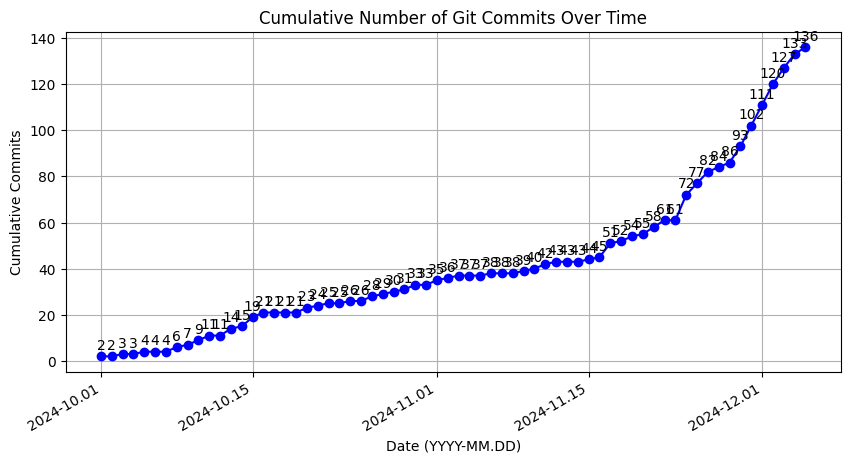

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_git_commits_csv = './sample_data/git_commits.csv'  # Path to your CSV file
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Group by date and count the number of commits (assuming 'repo' column exists)
df_grouped = df.groupby('date').size().reset_index(name='commits')

# Create a date range from the start to the end date in the data
date_range = pd.date_range(start=df_grouped['date'].min(), end=df_grouped['date'].max())

# Reindex the DataFrame to include all dates in the range and fill missing dates with 0 commits
df_grouped = df_grouped.set_index('date').reindex(date_range, fill_value=0).rename_axis('date').reset_index()

# Calculate cumulative commits for annotation
df_grouped['cumulative_commits'] = df_grouped['commits'].cumsum()

# Plot 1: Cumulative Commits Over Time
plt.figure(figsize=(10, 5))
plt.plot(df_grouped['date'], df_grouped['cumulative_commits'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Commits')
plt.title('Cumulative Number of Git Commits Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the cumulative number of commits
for i, row in df_grouped.iterrows():
    plt.annotate(row['cumulative_commits'], (row['date'], row['cumulative_commits']),
                 textcoords="offset points", xytext=(0,5), ha='center')

# Show the first plot
plt.show()


Total unique repositories: 67


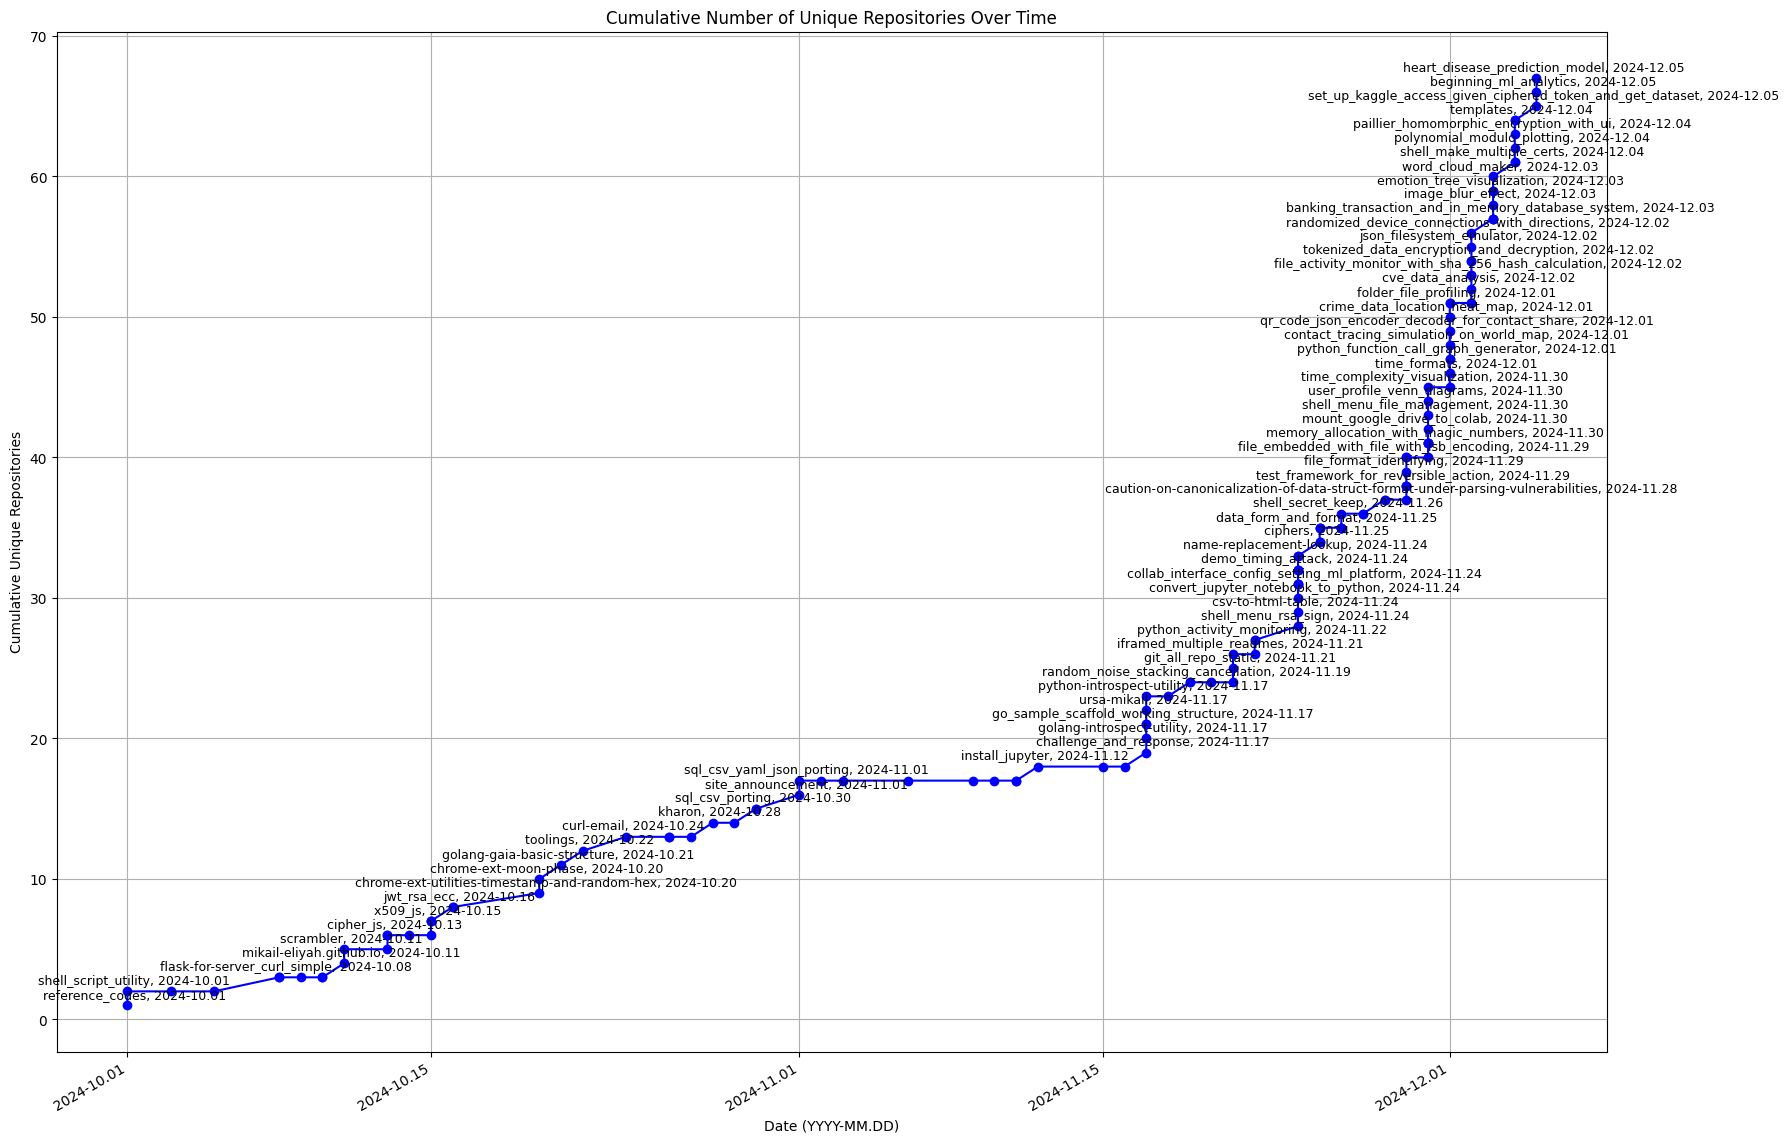

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(file_git_commits_csv)

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Clean repository names (standardize case and remove extra spaces)
df['repo'] = df['repo'].str.strip().str.lower()

# Sort by date to ensure that repos are processed in the correct order
df = df.sort_values(by='date')

# Remove duplicates to avoid counting the same repository on the same date
df = df.drop_duplicates(subset=['repo', 'date'])

# Keep track of unique repositories and their first check-in dates
repo_checkins = {}  # Dictionary to store the first check-in date for each repo

# List to accumulate the cumulative repo counts
repo_cumulative = []

# Loop through the dataframe and calculate the cumulative unique repo count
cumulative_repos = 0
for idx, row in df.iterrows():
    repo = row['repo']
    if repo not in repo_checkins:
        # First check-in for this repo
        repo_checkins[repo] = row['date']
        cumulative_repos += 1  # Increment the cumulative repo count
    repo_cumulative.append(cumulative_repos)

# Add the cumulative repo count to the dataframe
df['cumulative_repos'] = repo_cumulative

# Print the number of unique repositories to check the count
print(f"Total unique repositories: {df['repo'].nunique()}")

# Plot: Cumulative Unique Repositories Over Time
plt.figure(figsize=(20, 15))
plt.plot(df['date'], df['cumulative_repos'], marker='o', linestyle='-', color='b')
plt.xlabel('Date (YYYY-MM.DD)')
plt.ylabel('Cumulative Unique Repositories')
plt.title('Cumulative Number of Unique Repositories Over Time')
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m.%d'))
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

# Annotate the points with the first appearance of each repo
for idx, row in df.iterrows():
    if row['repo'] in repo_checkins and row['date'] == repo_checkins[row['repo']]:
        plt.annotate(f"{row['repo']}, {row['date'].strftime('%Y-%m.%d')}",
                     (row['date'], row['cumulative_repos']),
                     textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9)

# Show the plot
plt.show()
